In [1]:
from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
import warnings
from sklearn import preprocessing
import statsmodels.formula.api as smf
from sklearn.decomposition import PCA
from sklearn import linear_model

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.5f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

# Data

## Read

In [2]:
# Read in the crime data for Florida for 2016, listed by city
florida_crime = pd.read_excel('./florida_2017.xls')
florida_crime.columns = ['city', 'population', 'violent_crime', 'murder', 'rape', 'robbery',
       'assault', 'property_crime', 'burglary', 'larceny_theft',
       'motor_vehicle_theft', 'arson']
florida_crime.set_index('city', inplace=True)

crime_cols = ['violent_crime', 'murder', 'rape', 'robbery', 
              'assault', 'property_crime', 'burglary', 'larceny_theft', 
              'motor_vehicle_theft', 'arson']

## Inspect

In [69]:
florida_crime.describe()

,population,violent_crime,murder,rape,robbery,assault,property_crime,burglary,larceny_theft,motor_vehicle_theft,...,population_log,has_murder,has_rape,has_robbery,has_assault,has_property_crime,has_burglary,hss_larceny_theft,has_motor_vehicle_theft,has_arson
count,284.00000,284.00000,284.00000,284.00000,284.00000,284.00000,284.00000,284.00000,284.00000,284.00000,...,284.00000,284.00000,284.00000,284.00000,284.00000,284.00000,284.00000,284.00000,284.00000,284.00000
mean,35417.45423,170.28521,2.17254,14.31338,44.07394,109.72535,1129.05986,171.60563,863.82042,93.63380,...,9.43827,0.42606,0.74296,0.82042,0.92254,0.99648,0.98239,0.99296,0.92606,0.49648
std,74789.22599,467.35710,8.16537,40.50150,125.33079,300.15150,2725.22239,441.63691,2041.26924,254.30202,...,1.48517,0.49538,0.43777,0.38451,0.26780,0.05934,0.13175,0.08377,0.26214,0.50087
min,92.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,4.52179,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,4264.75000,9.00000,0.00000,0.00000,1.00000,5.75000,92.00000,16.00000,66.25000,5.00000,...,8.35810,0.00000,0.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,0.00000
50%,12871.50000,40.00000,0.00000,4.00000,7.00000,26.00000,348.50000,60.00000,266.00000,18.00000,...,9.46277,0.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,0.00000
75%,38706.50000,137.50000,1.00000,12.00000,29.25000,90.50000,1085.00000,162.00000,846.00000,76.00000,...,10.56376,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
max,894638.00000,5648.00000,109.00000,538.00000,1376.00000,3625.00000,31551.00000,5646.00000,22980.00000,2925.00000,...,13.70417,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000


/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 0, 'Log of Population')

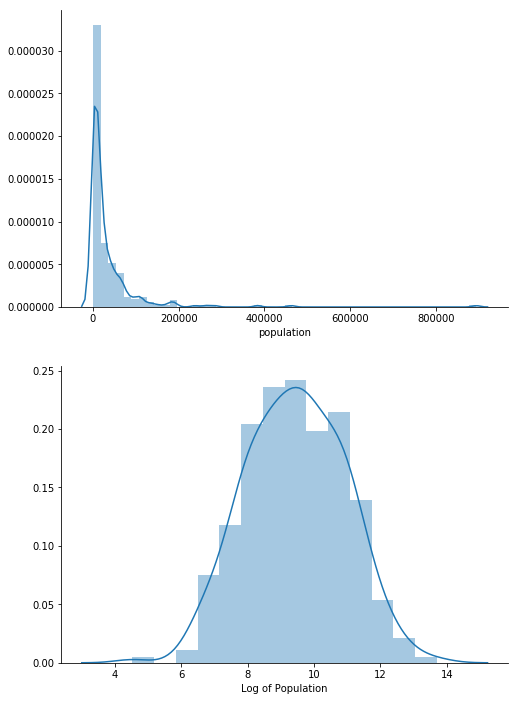

In [70]:
fig = plt.figure(figsize=(8,12))
ax1, ax2 = fig.subplots(2,1)
sns.distplot(florida_crime["population"], ax=ax1)
sns.despine(ax=ax1)
sns.distplot(np.log(florida_crime["population"]), ax=ax2)
sns.despine(ax=ax2)
ax2.set_xlabel("Log of Population")

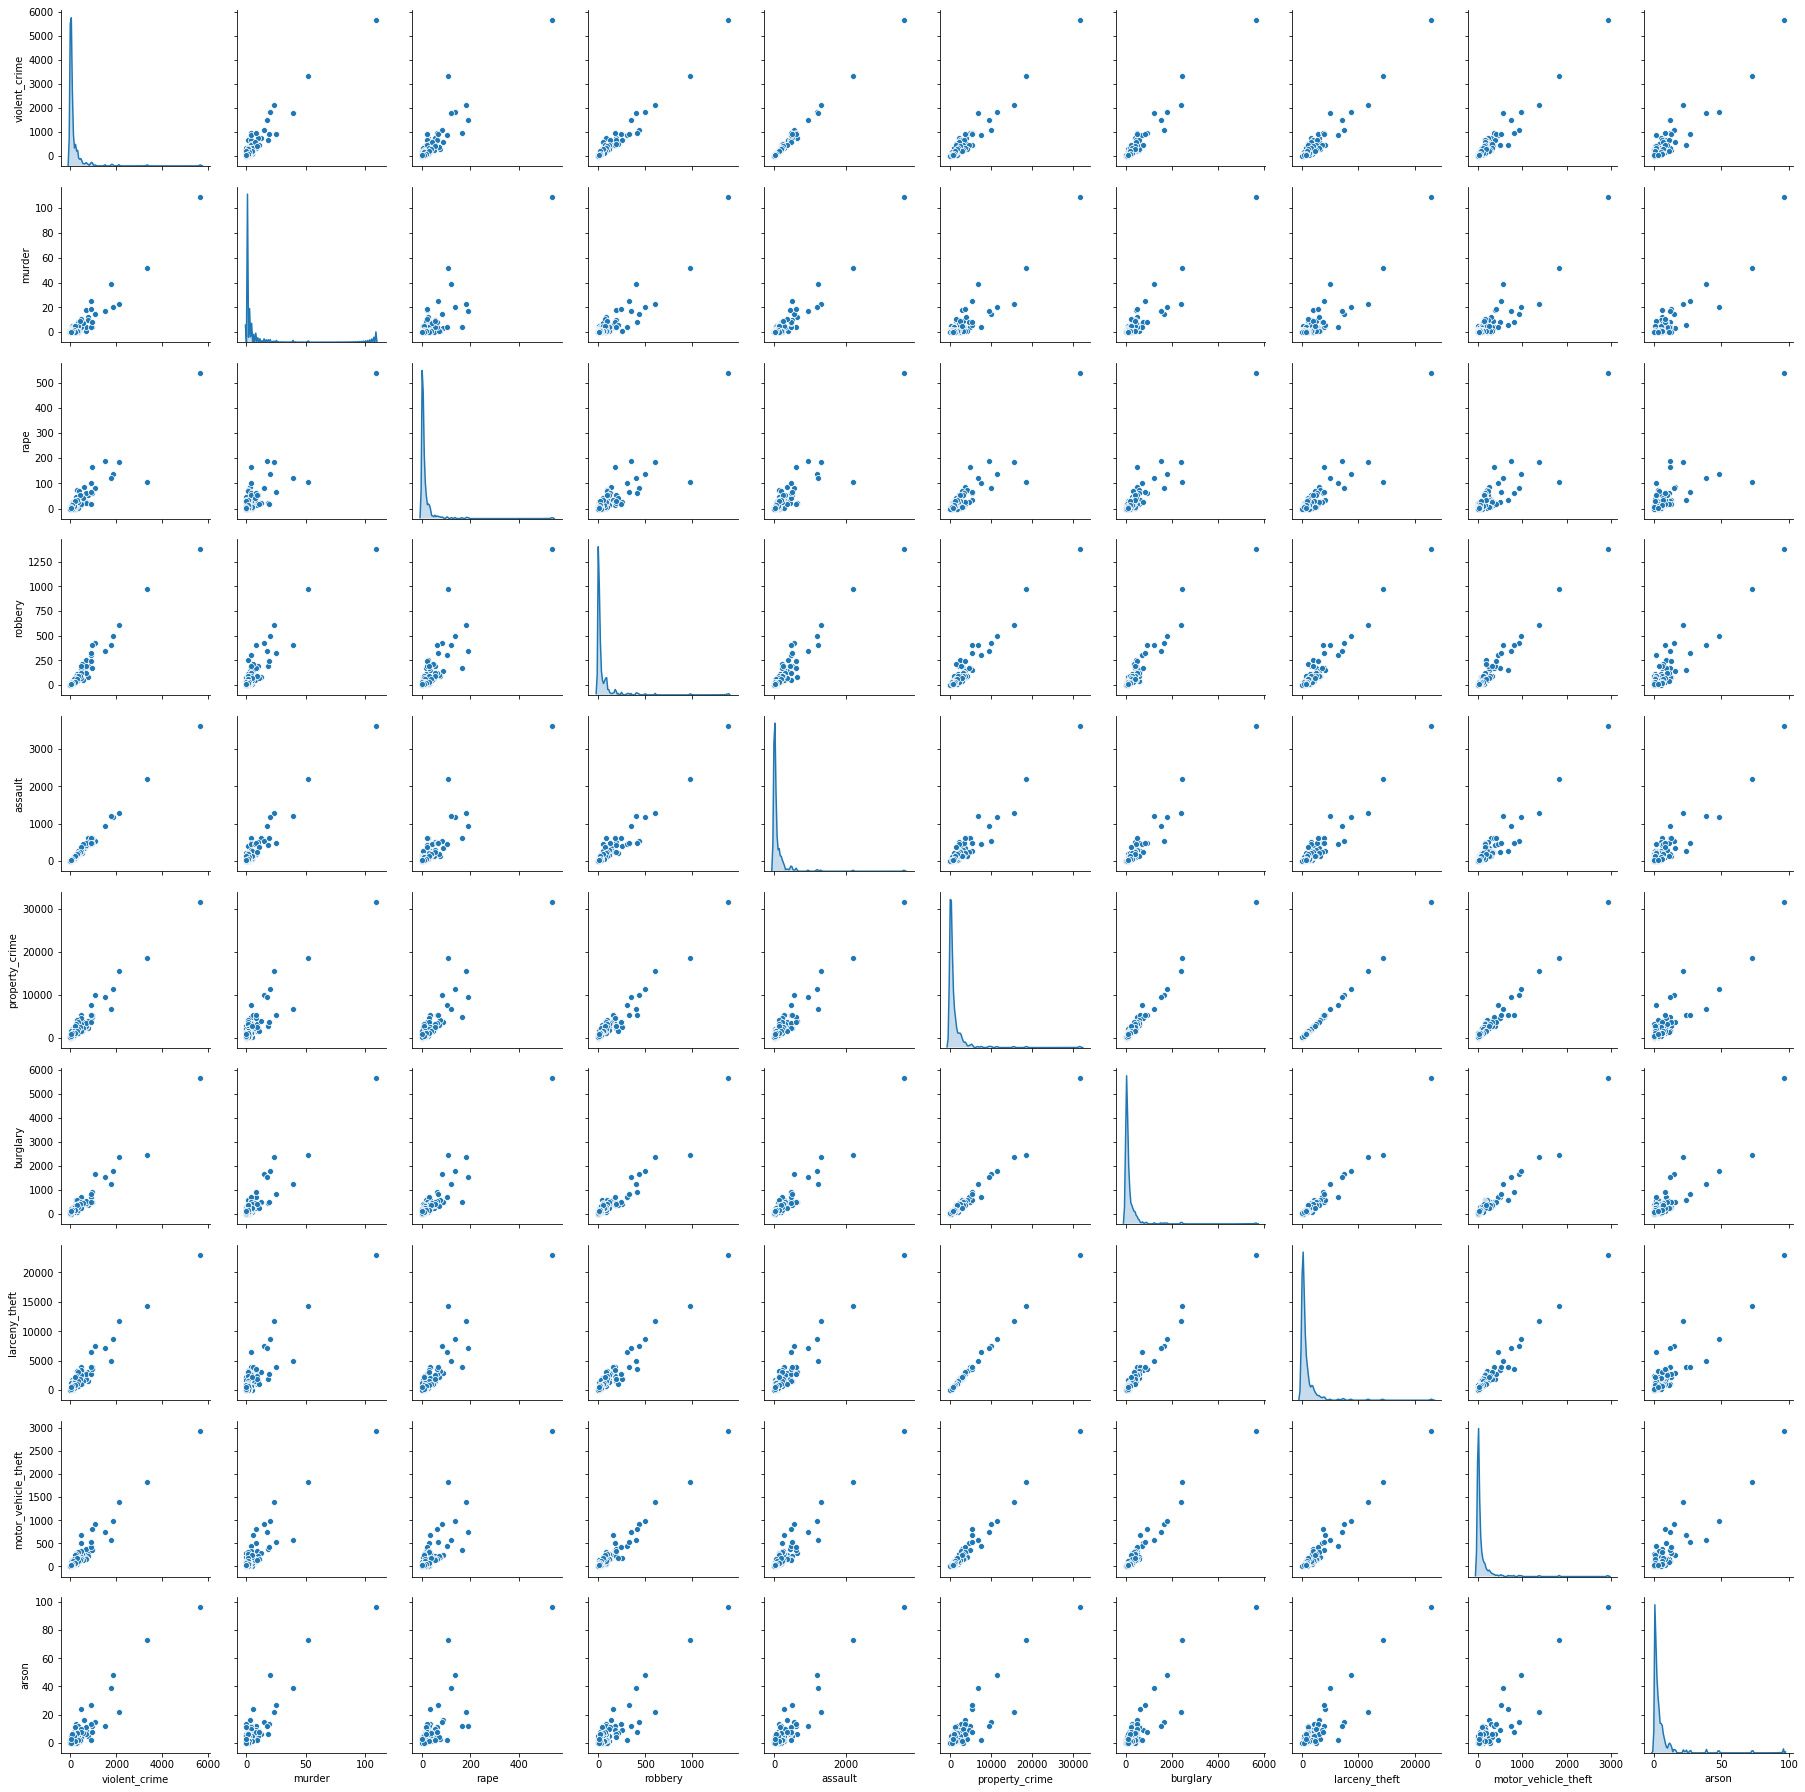

In [71]:
g = sns.pairplot(florida_crime, vars=crime_cols, diag_kind="kde")

So all crime metrics exhibit left skewness (my suspicion is population is quite correlated with each of these stats, and that is also quite left skewed however log transforming the population variable significantly reduces this skewness so lets log transform all of these as well.

## Clean

The only cleaning we are going to do here is to replace -inf values (in the crime_log cols) with a large negative number (in this case -100).

## Preprocess

In [3]:
florida_crime.fillna(florida_crime.median(), inplace=True)

In [4]:
# Based on some visual + mathematical concepts, we decided to split the population into 6 levels
def get_population_group(population, scaled=False):
    # scaling is used to space groups according to the ratio of that group's mean population
    # to the reference group. In this case we use group 1 as the reference
    # 3.25810, 8.73020, 24.61771, 52.12696, 146.88318
    
    
    if population in range(0, 3239):
        return 1
    if population in range(3239, 10000):
        if scaled:
            return 3.2
        else:
            return 2
    if population in range(10000,25000):
        if scaled:
            return 8.7
        else:
            return 3
    if population in range(25000, 75000):
        if scaled:
            return 24.6
        else:
            return 4
    if population in range(75000, 115245):
        if scaled:
            return 52.1
        else:
            return 5 
    if population >= 115245:
        if scaled:
            return 146.9
        else:
            return 6
    
florida_crime["population_group"] = florida_crime.population.apply(get_population_group)
florida_crime["population_group_scaled"] = florida_crime.population.apply(lambda x: get_population_group(x, True))

florida_crime["population_log"] = np.log(florida_crime.population)

In [5]:
florida_crime.groupby("population_group").mean()

,population,violent_crime,murder,rape,robbery,assault,property_crime,burglary,larceny_theft,motor_vehicle_theft,arson,population_group_scaled,population_log
population_group,,,,,,,,,,,,,
1,1858.68421,7.01754,0.12281,0.42105,0.91228,5.56140,54.84211,12.28070,38.57895,3.98246,0.10526,1.00000,7.37274
2,6024.25373,22.38806,0.35821,2.23881,3.62687,16.16418,142.70149,27.55224,106.62687,8.52239,0.34328,3.20000,8.65707
3,16399.55224,67.94030,0.61194,5.67164,15.01493,46.64179,511.08955,80.70149,396.58209,33.80597,1.22388,8.70000,9.67009
4,46609.24194,206.11290,2.29032,16.75806,51.19355,135.87097,1378.64516,206.66129,1066.41935,105.56452,3.41935,24.60000,10.70458
5,96018.93333,532.13333,6.53333,44.86667,162.46667,318.26667,3543.46667,481.53333,2743.06667,318.86667,6.80000,52.10000,11.46347
6,257510.00000,1321.75000,19.06250,112.43750,350.31250,839.93750,8443.43750,1296.68750,6384.18750,762.56250,23.81250,146.90000,12.29163


There are drastic differences in crime rates among cities with low populations versus medium and high populations. This implies using a separate model for low populations. The average population for the low group is 1132, 20,452 for the medium group and 186,334 for the high group. 

When comparing medium to high population cities, the murder rate is more than double in high population cities, saw almost twice as many arson cases and more than a 20% increase in rapes. Hopefully our model picks up on this fact.

The value that we wish to predict are property crimes, and in medium size cities the average was 604.7 and 6305.6 for high population cities: about a tenfold increase (for a little over a 9 fold increase in population).

In [15]:
cols = ['population', 'violent_crime', 'murder', 'rape', 'robbery', 
        'assault', 'property_crime', 'burglary', 'larceny_theft', 
        'motor_vehicle_theft', 'arson']
means = florida_crime.groupby("population_group")[cols].mean()
row1 = (means.iloc[1,:] / means.iloc[0,:]).values
row2 = (means.iloc[2,:] / means.iloc[0,:]).values
row3 = (means.iloc[3,:] / means.iloc[0,:]).values
row4 = (means.iloc[4,:] / means.iloc[0,:]).values
row5 = (means.iloc[5,:] / means.iloc[0,:]).values

ratios = np.array([row1, row2,row3,row4,row5])
ratios = pd.DataFrame(ratios)
ratios.columns = means.columns
# this is how much greater that group was in this variable (according to its mean) 
# RELATIVE to the ground group (group 1)
ratios

,population,violent_crime,murder,rape,robbery,assault,property_crime,burglary,larceny_theft,motor_vehicle_theft,arson
0,3.24114,3.19030,2.91684,5.31716,3.97560,2.90649,2.60204,2.24354,2.76386,2.13998,3.26119
1,8.82321,9.68149,4.98294,13.47015,16.45867,8.38669,9.31929,6.57141,10.27975,8.48872,11.62687
2,25.07647,29.37109,18.64977,39.80040,56.11600,24.43106,25.13844,16.82813,27.64252,26.50739,32.48387
3,51.65963,75.82900,53.20000,106.55833,178.08846,57.22776,64.61216,39.21057,71.10268,80.06784,64.60000
4,138.54424,188.34938,155.22321,267.03906,383.99639,151.02977,153.95903,105.58741,165.48371,191.48045,226.21875


In [16]:
ratios1 = (ratios.iloc[1,:] / ratios.iloc[0,:])
ratios2 = (ratios.iloc[2,:] / ratios.iloc[1,:])
ratios3 = (ratios.iloc[3,:] / ratios.iloc[2,:])
ratios4 = (ratios.iloc[4,:] / ratios.iloc[3,:])
df = pd.DataFrame(np.array([ratios1, ratios2, ratios3, ratios4]))
df.columns = means.columns
df.mean(axis=0)

population            2.57658
violent_crime         2.78351
murder                2.80534
rape                  2.66785
robbery               3.21980
assault               2.69502
property_crime        2.80802
burglary              2.62818
larceny_theft         2.82700
motor_vehicle_theft   3.12536
arson                 2.96240
dtype: float64

Essentially what this is saying is that group B has 2.6 times the population of group A (where B = A + 1). Of note are the variables:
  * _robbery_: multiplier of 3.27 and a standard deviation of 1.03
  * _motor-vehicle-theft_: multiplier of 3.2 and a standard deviation of 0.84
  * _arson_: multiplier of 3.2 and a standard deviation of 1.18
  
**Interpretation**: if group A grows by _x_ percent, we expect that crime _y_ will also grow by _x_ percent. Therefore, _robbery_, _motor-vehicle-theft_ and _arson_ all grow faster than population (non-linear).

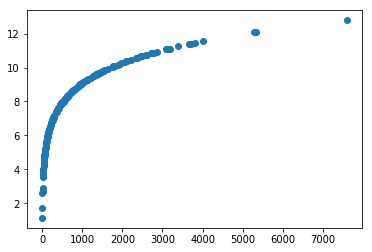

In [5]:
florida_crime = florida_crime[florida_crime.population.between(1180, 128637)]

# We can not transform 0 values, so just add 1 to all crime metrics
florida_crime["property_crime_2"] = florida_crime["property_crime"].apply(lambda x: x+1 if x == 0 else x)
florida_crime["robbery_2"] = florida_crime["robbery"] + 1
florida_crime["robbery_2_log"] = np.log(florida_crime["robbery_2"])
florida_crime["murder_2"] = florida_crime.murder + 1
florida_crime["murder_2_log"] = np.log(florida_crime["murder_2"])
florida_crime["violent_crime_2"] = florida_crime.violent_crime + 1
florida_crime["violent_crime_2_log"] = np.log(florida_crime["violent_crime_2"])
florida_crime["population_log"] = np.log(florida_crime.population)

from scipy.stats import boxcox

bc = boxcox(florida_crime['property_crime_2'])

plt.scatter(florida_crime["property_crime_2"], bc[0])
plt.show()

florida_crime['property_crime_bc'] = bc[0]

In [6]:
# Add some indicator variables
# play with these thresholds by looking at a scatterplot of crime1 vs. crime2, colored by
# drop the population outliers
florida_crime["population_low"] = florida_crime.population < 10000
florida_crime["population_medium"] = florida_crime.population.between(10000,75000)
florida_crime["population_high"] = florida_crime.population >= 75000

florida_crime["has_murder"] = np.where(florida_crime["murder"] > 0, 1, 0)
florida_crime["has_rape"] = np.where(florida_crime["rape"] > 0, 1, 0)
florida_crime["has_robbery"] = np.where(florida_crime["robbery"] > 0, 1, 0)
florida_crime["has_assault"] = np.where(florida_crime["assault"] > 0, 1, 0)
florida_crime["has_property_crime"] = np.where(florida_crime["property_crime"] > 0, 1, 0)
florida_crime["has_burglary"] = np.where(florida_crime["burglary"] > 0, 1, 0)
florida_crime["hss_larceny_theft"] = np.where(florida_crime["larceny_theft"] > 0, 1, 0)
florida_crime["has_motor_vehicle_theft"] = np.where(florida_crime["motor_vehicle_theft"] > 0, 1, 0)
florida_crime["has_arson"] = np.where(florida_crime["arson"] > 0, 1, 0)

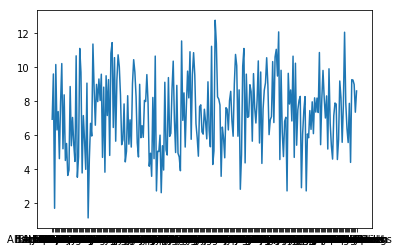

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


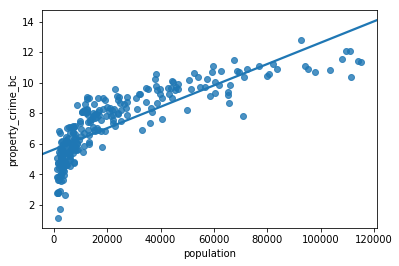

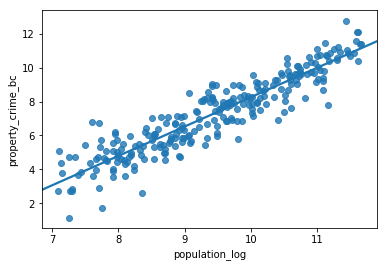

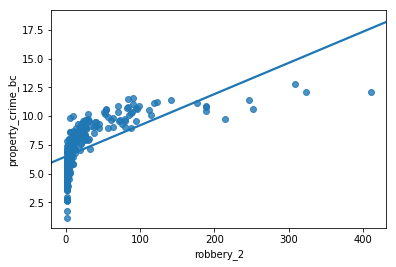

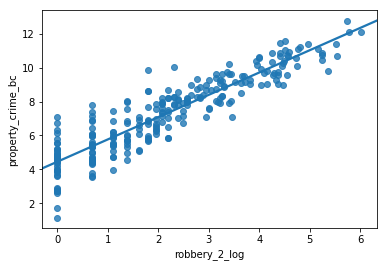

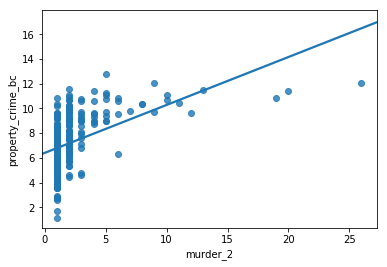

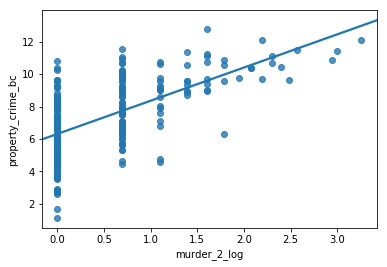

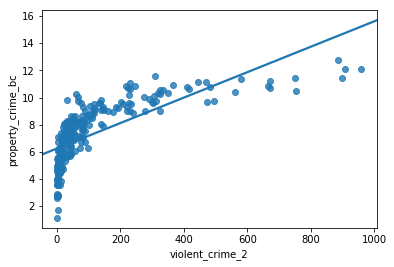

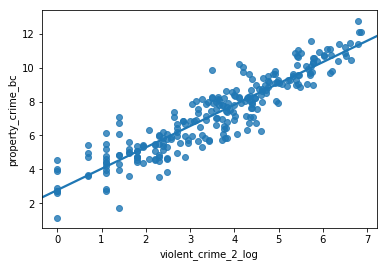

In [11]:
#test linearity between predictors & outcome...

plt.plot(florida_crime['property_crime_bc'])
plt.show()

sns.regplot(florida_crime['population'], florida_crime['property_crime_bc'], ci = False)
plt.show()

sns.regplot(florida_crime['population_log'], florida_crime['property_crime_bc'], ci = False)
plt.show()

sns.regplot(florida_crime['robbery_2'], florida_crime['property_crime_bc'], ci = False)
plt.show()

sns.regplot(florida_crime['robbery_2_log'], florida_crime['property_crime_bc'], ci = False)
plt.show()

sns.regplot(florida_crime['murder_2'], florida_crime['property_crime_bc'], ci = False)
plt.show()

sns.regplot(florida_crime['murder_2_log'], florida_crime['property_crime_bc'], ci = False)
plt.show()

sns.regplot(florida_crime['violent_crime_2'], florida_crime['property_crime_bc'], ci = False)
plt.show()

sns.regplot(florida_crime['violent_crime_2_log'], florida_crime['property_crime_bc'], ci = False)
plt.show()

## Split

In [7]:
# Do a 70/30 split
train = florida_crime.sample(frac=0.7, random_state=41)
test_cities = list(set(florida_crime.index).difference(set(train.index)))
test = florida_crime.loc[test_cities,:]
train.corr()

,population,violent_crime,murder,rape,robbery,assault,property_crime,burglary,larceny_theft,motor_vehicle_theft,...,population_high,has_murder,has_rape,has_robbery,has_assault,has_property_crime,has_burglary,hss_larceny_theft,has_motor_vehicle_theft,has_arson
population,1.00000,0.77630,0.58291,0.76889,0.74952,0.73644,0.92289,0.86677,0.92233,0.87518,...,0.72193,0.50578,0.37904,0.35544,0.20741,nan,0.06614,nan,0.21192,0.54417
violent_crime,0.77630,1.00000,0.83102,0.78558,0.94090,0.98513,0.88838,0.91086,0.86731,0.89589,...,0.59230,0.50761,0.32145,0.28850,0.16067,nan,0.04981,nan,0.16802,0.48350
murder,0.58291,0.83102,1.00000,0.50434,0.82103,0.81238,0.69383,0.71593,0.66823,0.77006,...,0.43177,0.47272,0.20478,0.17827,0.10420,nan,0.03210,nan,0.10962,0.33238
rape,0.76889,0.78558,0.50434,1.00000,0.73455,0.72832,0.80789,0.83691,0.80032,0.70292,...,0.61429,0.45564,0.34626,0.27562,0.15206,nan,0.04834,nan,0.15732,0.49580
robbery,0.74952,0.94090,0.82103,0.73455,1.00000,0.87511,0.85657,0.87846,0.83048,0.91239,...,0.62415,0.47445,0.28643,0.25991,0.13888,nan,0.04339,nan,0.14769,0.43308
assault,0.73644,0.98513,0.81238,0.72832,0.87511,1.00000,0.85228,0.87246,0.83334,0.85089,...,0.53514,0.49230,0.31293,0.28450,0.16112,nan,0.04964,nan,0.16760,0.47235
property_crime,0.92289,0.88838,0.69383,0.80789,0.85657,0.85228,1.00000,0.95744,0.99748,0.93573,...,0.70564,0.51788,0.35466,0.33492,0.19124,nan,0.06039,nan,0.20086,0.54006
burglary,0.86677,0.91086,0.71593,0.83691,0.87846,0.87246,0.95744,1.00000,0.93841,0.90537,...,0.63718,0.53586,0.34497,0.32884,0.19981,nan,0.06349,nan,0.20762,0.53559
larceny_theft,0.92233,0.86731,0.66823,0.80032,0.83048,0.83334,0.99748,0.93841,1.00000,0.91694,...,0.70753,0.50970,0.35531,0.33508,0.18945,nan,0.05978,nan,0.19899,0.53883
motor_vehicle_theft,0.87518,0.89589,0.77006,0.70292,0.91239,0.85089,0.93573,0.90537,0.91694,1.00000,...,0.68983,0.47977,0.31028,0.29195,0.16370,nan,0.05137,nan,0.17539,0.47510


So the input crime features are all highly correlated, so we need to transform them.

## PCA

In [8]:
# DO NOT include population or property_crime
cols_to_pca = ['violent_crime', 'murder', 'rape', 'robbery', 
               'assault', 'burglary', 'larceny_theft', 
               'motor_vehicle_theft', 'arson']

scaled = pd.DataFrame(preprocessing.scale(train[cols_to_pca]))
scaled.columns = cols_to_pca
scaled.head()

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  


,violent_crime,murder,rape,robbery,assault,burglary,larceny_theft,motor_vehicle_theft,arson
0,-0.19428,-0.42711,-0.24519,-0.51694,-0.02178,-0.40893,-0.23455,-0.34527,-0.55236
1,-0.27625,-0.11553,-0.24519,-0.39623,-0.21066,0.29832,1.14761,0.79305,0.02599
2,-0.42846,-0.42711,-0.31151,-0.55717,-0.35457,-0.37321,-0.32093,-0.32273,-0.26319
3,1.38643,1.75394,1.47931,1.19300,1.34538,1.39847,1.37088,1.08608,1.76107
4,-0.34650,-0.42711,-0.24519,-0.07436,-0.45351,-0.02316,-0.16012,-0.19875,-0.26319


In [9]:
# now PCA this scaled 
pca = PCA(n_components=3)
pca.fit(scaled)
components = pca.transform(scaled)
components = pd.DataFrame(components, columns=[ "PC" + str(i) for i in range(1,components.shape[1]+1) ])
components.index = train.index
train = train.join(components)
print("Variance explained: {}".format(pca.explained_variance_ / pca.explained_variance_.sum()))
train.head()

Variance explained: [0.88570222 0.06796217 0.0463356 ]


,population,violent_crime,murder,rape,robbery,assault,property_crime,burglary,larceny_theft,motor_vehicle_theft,...,has_robbery,has_assault,has_property_crime,has_burglary,hss_larceny_theft,has_motor_vehicle_theft,has_arson,PC1,PC2,PC3
city,,,,,,,,,,,,,,,,,,,,,
Cocoa Beach,11851,80,0,6,3,71,516,61,425,30,...,1,1,1,1,1,1,0,-0.96845,-0.07573,-0.28618
Doral,60239,66,1,6,9,50,1756,160,1465,131,...,1,1,1,1,1,1,1,0.35731,-0.36088,-0.44443
Lynn Haven,21262,40,0,5,1,34,458,66,360,32,...,1,1,1,1,1,1,1,-1.12413,-0.11803,0.03725
Kissimmee,71130,350,7,32,88,223,2104,314,1633,157,...,1,1,1,1,1,1,1,4.21618,0.09292,0.68487
Eustis,21161,54,0,6,25,23,639,115,481,43,...,1,1,1,1,1,1,1,-0.72075,-0.19811,-0.11658


So the first 3 principal components explain almost all of the variance that existed in the 10 crime variables. 

## Model

In [21]:
formula = "property_crime_bc ~ population_log + robbery_2_log + violent_crime_2_log"
lm1 = smf.ols(formula=formula, data=train).fit()
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      property_crime_bc   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     614.0
Date:                Mon, 10 Dec 2018   Prob (F-statistic):          4.93e-101
Time:                        11:37:22   Log-Likelihood:                -160.33
No. Observations:                 178   AIC:                             330.7
Df Residuals:                     173   BIC:                             346.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -3.3482      0.544     -6.152      0.000      -4.422      -2.274
population_log          0.8716      0.070     12.402      0.000       0.733       1.010
robbery_2_log           0.2295      0.083      2.759      0.006       0.065       0.394
violent_crime_2_log     0.5258      0.084      6.296      0.000       0.361       0.691
has_murder              0.0875      0.114      0.769      0.443      -0.137       0.312
==============================================================================
Omnibus:                       17.167   Durbin-Watson:                   2.162
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               62.938
Skew:                          -0.006   Prob(JB):                     2.15e-14
Kurtosis:                       5.913   Cond. No.                         129.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
lm1.pvalues

Intercept             0.00000
population_log        0.00000
robbery_2_log         0.00642
violent_crime_2_log   0.00000
has_murder            0.44276
dtype: float64

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


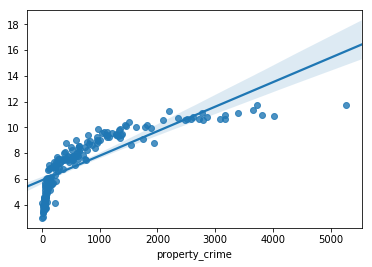

In [23]:
predicted = lm1.fittedvalues.ravel()
actual = train['property_crime']

residual = actual - predicted

sns.regplot(actual, predicted)
plt.show()

In [28]:
formula_new = "property_crime ~ population_low + population_medium + PC1 + PC2 + PC3"
lm_new = smf.ols(formula=formula_new, data=train).fit()
lm_new.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         property_crime   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     659.2
Date:                Mon, 10 Dec 2018   Prob (F-statistic):          3.65e-110
Time:                        11:39:46   Log-Likelihood:                -1208.9
No. Observations:                 178   AIC:                             2430.
Df Residuals:                     172   BIC:                             2449.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                  1160.5838     91.343     12.706      0.000     980.286    1340.881
population_low[T.True]     -505.0688    108.954     -4.636      0.000    -720.128    -290.010
population_medium[T.True]  -340.2642     91.076     -3.736      0.000    -520.034    -160.494
PC1                         299.9731      9.604     31.233      0.000     281.015     318.931
PC2                        -173.2278     23.640     -7.328      0.000    -219.889    -126.566
PC3                        -182.3989     27.163     -6.715      0.000    -236.014    -128.783
==============================================================================
Omnibus:                       42.178   Durbin-Watson:                   2.096
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              661.637
Skew:                          -0.021   Prob(JB):                    2.12e-144
Kurtosis:                      12.445   Cond. No.                         27.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
lm_new.pvalues

Intercept                   0.00000
population_low[T.True]      0.00001
population_medium[T.True]   0.00025
PC1                         0.00000
PC2                         0.00000
PC3                         0.00000
dtype: float64

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


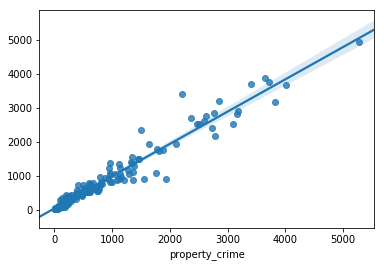

In [30]:
predicted = lm_new.fittedvalues.ravel()
actual = train['property_crime']

residual = actual - predicted

sns.regplot(actual, predicted)
plt.show()

In [31]:
lm_new.co

3.6471843931503094e-110

So now we have a really good R^2 value, and the f-test p-value is smaller than that of the original model, indicating that it is extremely unlikely to get an R^2 value like this by random chance. The 95% confidence intervals are quite large, indicating that there is a good amount of uncertainty in the model estimates. The final formula for this model is:

\begin{equation}\label{eq:pc_all}
PropertyCrime = -505.1*population_{low} - 340.3*population_{medium} + 300*PC1 - 173.2*PC2 - 182.4*PC3
\end{equation}


The population_group_scaled factor variable is: {1, 3.2, 8.7, 24.6, 52.1, 149.6}

population_low: 0 < population < 10,000
population_medium: 10,000 < population < 75,000
population_high: population > 75,000





# Evaluate

Now let's see how this model performs on the test set. For this, we are going to need to apply the same transformations that we did above. When scaling though, we must use the mean and standard deviation of the train set for each feature (as we can not "look ahead" and get the mean and standard deviation of the complete test set).

## Evaluate

In [33]:
print("Average property crime: {}".format(train["property_crime"].mean()))
print("Average error made by model: {}".format(lm1.resid.mean()))
print("Average error standard deviation: {}".format(lm1.resid.std()))

Average property crime: 780.3595505617977
Average error made by model: -3.522775080383643e-15
Average error standard deviation: 0.5972829233331082


In [36]:
print('REVISED MODEL\n-------------------------------------------------------')
print("Average property crime: {}".format(train["property_crime"].mean()))
print("Average error made by model: {}".format(lm_new.resid.mean()))
print("Average error standard deviation: {}".format(lm_new.resid.std()))

REVISED MODEL
-------------------------------------------------------
Average property crime: 780.3595505617977
Average error made by model: -1.3093147040972633e-13
Average error standard deviation: 216.09028311252106


## Revise


I actually iteratively went through this process, but did not write down the formula used at each step.

# Conclusions